In [194]:
import pandas as pd
import numpy as np
import os
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm

pd.set_option('display.max_columns', None)  
pd.set_option("display.max_rows", 51)


In [195]:
def create_additional_vars(df):
    df['xG'] = df['goals_scored'] + df['big_chances_missed'] + df['penalties_missed']
    df['xA'] = df['assists'] + df['big_chances_created']
    df['net_transfers'] = df['transfers_in'] - df['transfers_out']
    return df

def lagged_player_features(df, var_dict, predicted_round = 10, lagged_rounds = 5):
    df.sort_values(['player_id', 'round'], inplace=True)
    end_hist = predicted_round - 1
    start_hist = end_hist - lagged_rounds
    df = df[(df['round'] >= start_hist) & (df['round'] <= end_hist)]
    group_vars = ['player_id']
    df = df.groupby(group_vars, as_index=False).agg(var_dict)
    rename_cols = [col for col in df.columns if col not in group_vars]
    rename_dict = dict(zip(rename_cols,[f'{col}_{lagged_rounds}' for col in rename_cols]))
    df.rename(columns=rename_dict, inplace=True)
    df['round'] = predicted_round
    #df.set_index('player_id',inplace=True)
    return df

def get_targets(df, predicted_round = 10):
    df = df.loc[df['round'] == predicted_round, ['player_id', 'round', 'total_points']]
#     df.set_index('player_id',inplace=True)
    return df

def lagged_team_features(df, var_dict, predicted_round, lagged_rounds):
    return None

def opponent_features(df, var_dict, predicted_round, lagged_rounds):
    return None

def get_players(df, position):
    if position not in ['Goalkeeper', 'Defender', 'Midfielder', 'Forward']:
        print('Error: Wrong position given')
        return None
    else:
        conds = (df['pos'] == position)
        correct_position = list(df.loc[conds,'player_id'].unique())
        return correct_position

def compile_data(df, start_round, end_round, var_dict, lagged_rounds, position):
    features = pd.DataFrame()
    targets = pd.DataFrame()

    for i in range(start_round,end_round+1):
        temp_features = lagged_player_features(df=df, 
                                               var_dict=var_dict, 
                                               predicted_round=i, 
                                               lagged_rounds=lagged_rounds)
        
        features = pd.concat([features, temp_features])

        temp_targets = get_targets(df,predicted_round=i)
        targets = pd.concat([targets, temp_targets])

    player_list = get_players(df, position=position)
    
    min_minutes_df = features.loc[(features['minutes_5'] > 90) & 
                                  (features['player_id'].isin(player_list)), 
                                  ['player_id', 'round']]

    features = features.merge(min_minutes_df).set_index(['player_id', 'round']).sort_index()
    targets = targets.merge(min_minutes_df).set_index(['player_id', 'round']).sort_index()

    check_indexes_match = (features.index != targets.index).sum() == 0 

    if check_indexes_match:
        return features, targets
    else:
        print('ERROR: Indexes do not match. Check Code')

# Fantasy Premier League

### Objectives 
1. Model that predicts player game performance as a function of past individual performance, team performance, and opponent performance
    - Clean up code (especially train/tune/test) framework
    - Add info about opponents
    - Dont train test on the same weeks ?
2. Model to choose team (constrained optimization problem)
3. Model for tweaking existing lineup 

### Functions 

In [196]:
# def get_data():
#     data_path = os.getcwd() + '/data'
#     seasons = ['fpl_data18-19']
#     data_path = os.getcwd() + '/data/' + seasons[0] + '.xlsx'
#     print(f'reading in {data_path} ...')
#     df = pd.read_excel(data_path)
#     return df

# def create_additional_vars(df):
#     df['xG'] = df['goals_scored'] + df['big_chances_missed'] + df['penalties_missed']
#     df['xA'] = df['assists'] + df['big_chances_created']
#     df['net_transfers'] = df['transfers_in'] - df['transfers_out']
#     return df

# def lagged_player_features(df, var_dict, predicted_round = 10, lagged_rounds = 5):
#     df.sort_values(['player_id', 'round'], inplace=True)
#     end_hist = predicted_round - 1
#     start_hist = end_hist - lagged_rounds
#     df = df[(df['round'] >= start_hist) & (df['round'] <= end_hist)]
#     group_vars = ['player_id']
#     df = df.groupby(group_vars, as_index=False).agg(var_dict)
#     rename_cols = [col for col in df.columns if col not in group_vars]
#     rename_dict = dict(zip(rename_cols,[f'{col}_{lagged_rounds}' for col in rename_cols]))
#     df.rename(columns=rename_dict, inplace=True)
#     df['round'] = predicted_round
#     #df.set_index('player_id',inplace=True)
#     return df

# def get_targets(df, predicted_round = 10):
#     df = df.loc[df['round'] == predicted_round, ['player_id', 'round', 'total_points']]
# #     df.set_index('player_id',inplace=True)
#     return df

# def lagged_team_features(df, var_dict, predicted_round, lagged_rounds):
#     return None

# def opponent_features(df, var_dict, predicted_round, lagged_rounds):
#     return None

# def get_players(df, position):
#     if position not in ['Goalkeeper', 'Defender', 'Midfielder', 'Forward']:
#         print('Error: Wrong position given')
#         return None
#     else:
#         conds = (df['pos'] == position)
#         correct_position = list(df.loc[conds,'player_id'].unique())
#         return correct_position



In [197]:
df = get_data()
display(df.head())
df.describe()


reading in /Users/jasongoldrosen/Documents/Jason/fantasy_epl/data/fpl_data18-19.xlsx ...


,player_id,id,kickoff_time,kickoff_time_formatted,team_h_score,team_a_score,was_home,round,total_points,value,transfers_balance,selected,transfers_in,transfers_out,loaned_in,loaned_out,minutes,goals_scored,assists,clean_sheets,goals_conceded,own_goals,penalties_saved,penalties_missed,yellow_cards,red_cards,saves,bonus,bps,influence,creativity,threat,ict_index,ea_index,open_play_crosses,big_chances_created,clearances_blocks_interceptions,recoveries,key_passes,tackles,winning_goals,attempted_passes,completed_passes,penalties_conceded,big_chances_missed,errors_leading_to_goal,errors_leading_to_goal_attempt,tackled,offside,target_missed,fouls,dribbles,element,fixture,opponent_team,name,team,pos,difficulty,opponents,venue,team_goals,opposition_goals,game_id
0,1,1,2018-08-12T15:00:00Z,2020-08-12 16:00:00,0,2,True,1,3,5.0,0,70767,0,0,0,0,90,0,0,0,2,0,0,0,0,0,6,0,24,47.0,0.0,0,4.7,0,0,0,2,9,0,0,0,42,31,0,0,0,0,0,0,0,0,0,1,1,13,Cech,Arsenal,Goalkeeper,4,Man City,H,0,0,1
1,1,526,2018-08-18T16:30:00Z,2020-08-18 17:30:00,3,2,False,2,3,5.0,188,90038,6059,5871,0,0,90,0,0,0,3,0,0,0,0,0,8,0,26,53.0,0.0,0,5.3,0,0,0,1,8,0,0,0,35,25,0,0,0,0,0,0,0,0,0,1,14,6,Cech,Arsenal,Goalkeeper,4,Chelsea,A,2,2,2
2,1,1053,2018-08-25T14:00:00Z,2020-08-25 15:00:00,3,1,True,3,3,5.0,8540,107301,19550,11010,0,0,90,0,0,0,1,0,0,0,0,0,4,0,17,27.8,0.0,0,2.8,0,0,0,0,10,0,0,0,24,20,0,0,0,0,0,0,0,0,0,1,21,19,Cech,Arsenal,Goalkeeper,3,West Ham,H,3,3,3
3,1,1584,2018-09-02T12:30:00Z,2020-09-02 13:30:00,2,3,False,4,1,5.0,9582,123566,19332,9750,0,0,90,0,0,0,2,0,0,0,0,0,1,0,8,2.4,0.0,0,0.2,0,0,0,0,8,0,0,0,38,24,0,0,0,2,0,0,0,0,0,1,33,5,Cech,Arsenal,Goalkeeper,2,Cardiff,A,3,3,4
4,1,2121,2018-09-15T14:00:00Z,2020-09-15 15:00:00,1,2,False,5,2,5.0,-3297,123310,8837,12134,0,0,90,0,0,0,1,0,0,0,0,0,1,0,13,14.2,0.0,0,1.4,0,0,0,2,13,0,0,0,33,23,0,0,0,0,0,0,0,0,0,1,46,15,Cech,Arsenal,Goalkeeper,2,Newcastle,A,2,2,5


,player_id,id,team_h_score,team_a_score,round,total_points,value,transfers_balance,selected,transfers_in,transfers_out,loaned_in,loaned_out,minutes,goals_scored,assists,clean_sheets,goals_conceded,own_goals,penalties_saved,penalties_missed,yellow_cards,red_cards,saves,bonus,bps,influence,creativity,threat,ict_index,ea_index,open_play_crosses,big_chances_created,clearances_blocks_interceptions,recoveries,key_passes,tackles,winning_goals,attempted_passes,completed_passes,penalties_conceded,big_chances_missed,errors_leading_to_goal,errors_leading_to_goal_attempt,tackled,offside,target_missed,fouls,dribbles,element,fixture,opponent_team,difficulty,team_goals,opposition_goals,game_id
count,11531.000000,11531.000000,11531.000000,11531.000000,11531.000000,11531.000000,11531.000000,1.153100e+04,1.153100e+04,11531.000000,1.153100e+04,11531.0,11531.0,11531.000000,11531.000000,11531.000000,11531.000000,11531.000000,11531.000000,11531.000000,11531.000000,11531.000000,11531.000000,11531.000000,11531.000000,11531.000000,11531.000000,11531.000000,11531.000000,11531.000000,11531.0,11531.000000,11531.000000,11531.000000,11531.000000,11531.000000,11531.000000,11531.000000,11531.000000,11531.000000,11531.000000,11531.000000,11531.000000,11531.000000,11531.000000,11531.000000,11531.000000,11531.000000,11531.000000,11531.000000,11531.000000,11531.000000,11531.000000,11531.000000,11531.000000,11531.000000
mean,275.212211,5766.000000,1.510450,1.333102,11.147602,1.485647,5.193886,8.498829e-03,1.560822e+05,10530.572283,1.053056e+04,0.0,0.0,35.899315,0.050386,0.044922,0.108750,0.570462,0.001474,0.000954,0.001127,0.059058,0.002688,0.110051,0.116035,6.600035,8.275986,5.300139,5.897494,1.945989,0.0,0.102333,0.051773,1.371954,2.219148,0.335357,0.235973,0.013876,16.753534,13.350880,0.005030,0.040500,0.005550,0.014223,0.611656,0.077010,0.176221,0.386176,0.282196,275.212211,106.992195,10.468390,2.969040,1.416876,1.416876,10.852398
std,158.800949,3328.857311,1.325103,1.167185,6.051218,2.593346,1.258427,4.736117e+04,3.477455e+05,39366.235348,3.442085e+04,0.0,0.0,41.185734,0.242087,0.225966,0.311339,1.015982,0.038370,0.030873,0.033559,0.235744,0.051782,0.681393,0.507767,10.015016,13.539107,11.022513,13.920013,3.145229,0.0,0.398310,0.248515,2.664040,3.157601,0.798208,0.633615,0.116980,23.147503,19.819319,0.071962,0.217629,0.076595,0.122020,1.296971,0.340859,0.492434,0.791507,0.740932,158.800949,60.576592,5.768061,0.954559,1.248662,1.248662,6.051218
min,1.000000,1.000000,0.000000,0.000000,1.000000,-4.000000,3.800000,-1.156152e+06,0.000000e+00,0.000000,0.000000e+00,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-12.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,2.000000,0.000000,0.000000,1.000000
25%,138.000000,2883.500000,0.000000,0.000000,6.000000,0.000000,4.400000,-2.092500e+03,6.682500e+03,55.000000,2.265000e+02,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,138.000000,55.000000,5.000000,2.000000,0.000000,0.000000,6.000000
50%,275.000000,5766.000000,1.000000,1.000000,11.000000,0.000000,4.900000,-1.850000e+02,2.657600e+04,374.000000,1.318000e+03,0.0,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,275.000000,108.000000,10.000000,3.000000,1.000000,1.000000,11.000000


In [198]:
positions = list(df.pos.unique())
positions

['Goalkeeper', 'Defender', 'Midfielder', 'Forward']

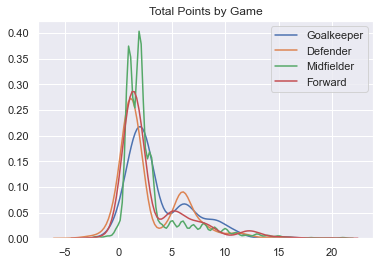

In [199]:
plt.close()

for p in positions:
    sns.kdeplot(df[(df.pos == p) & (df.minutes > 0)].total_points, label=p)
plt.title('Total Points by Game')
plt.show()

# Updated Flow

In [200]:
df = get_data()
df = create_additional_vars(df)

agg_dict= {
           'xG':'sum', 
           'xA':'sum',
           'team_goals':'sum',
           'ict_index': 'last',
           'value': 'last',
           'minutes': 'sum',
           'total_points':'mean'
            }


reading in /Users/jasongoldrosen/Documents/Jason/fantasy_epl/data/fpl_data18-19.xlsx ...


In [201]:
train_features, train_targets = compile_data(df=df, 
                                            start_round=6, 
                                            end_round=15, 
                                            var_dict=agg_dict, 
                                            lagged_rounds=5,
                                            position = 'Midfielder')

test_features, test_targets = compile_data(df=df, 
                                            start_round=16, 
                                            end_round=21, 
                                            var_dict=agg_dict, 
                                            lagged_rounds=5,
                                            position = 'Midfielder')


                            OLS Regression Results                            
Dep. Variable:           total_points   R-squared:                       0.106
Model:                            OLS   Adj. R-squared:                  0.102
Method:                 Least Squares   F-statistic:                     26.29
Date:                Sat, 11 Jul 2020   Prob (F-statistic):           1.09e-29
Time:                        18:01:13   Log-Likelihood:                -3263.5
No. Observations:                1339   AIC:                             6541.
Df Residuals:                    1332   BIC:                             6577.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.5203      0.360     -1.

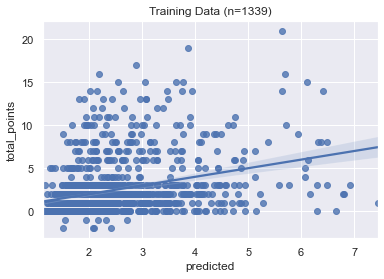

Train RMSE:  2.7686


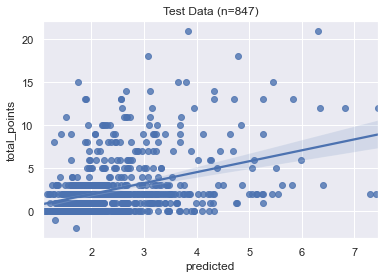

Train RMSE:  2.8664


In [202]:
cols = ['value_5', 'xG_5','xA_5','ict_index_5','team_goals_5', 'total_points_5']
cols = ['value_5', 'xG_5','xA_5','ict_index_5','team_goals_5', 'total_points_5']
def calc_rmse(df):
    return (((df['predicted'] - df['total_points']) ** 2).mean()) ** .5

X = sm.add_constant(train_features[cols])
y = train_targets

mod = sm.OLS(y, X)
res = mod.fit()
print(res.summary())
y_pred = res.predict(X)

# df = y.merge(y_pred, left_index=True,right_index=True)
df = y.copy()
df['predicted'] = y_pred
plt.close()
# g = sns.scatterplot(x='predicted',y='total_points', data=df)
ax = sns.regplot(x='predicted',y='total_points', data=df)
ax.set_title(f'Training Data (n={len(y)})')
plt.show()
print(f'Train RMSE: {calc_rmse(df): 0.04f}')

#Test Data

X = sm.add_constant(test_features[cols])
y = test_targets
y_pred = res.predict(X)

df = y.copy()
df['predicted'] = y_pred
plt.close()
ax = sns.regplot(x='predicted',y='total_points', data=df)
ax.set_title(f'Test Data (n={len(y)})')
plt.show()
print(f'Train RMSE: {calc_rmse(df): 0.04f}')



## Aggregating across multiple weeks

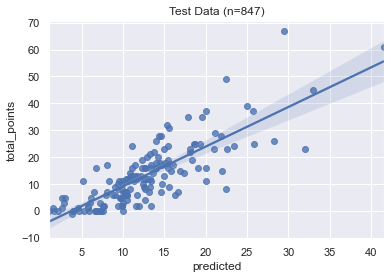

Train RMSE:  7.3705


In [203]:
df = df.reset_index().groupby('player_id')[['total_points', 'predicted']].sum()

plt.close()
ax = sns.regplot(x='predicted',y='total_points', data=df)
ax.set_title(f'Test Data (n={len(y)})')
plt.show()
print(f'Train RMSE: {calc_rmse(df): 0.04f}')



# Other positions

In [205]:
positions

['Goalkeeper', 'Defender', 'Midfielder', 'Forward']

In [230]:
df = get_data()
df = create_additional_vars(df)
df.head()

reading in /Users/jasongoldrosen/Documents/Jason/fantasy_epl/data/fpl_data18-19.xlsx ...


,player_id,id,kickoff_time,kickoff_time_formatted,team_h_score,team_a_score,was_home,round,total_points,value,transfers_balance,selected,transfers_in,transfers_out,loaned_in,loaned_out,minutes,goals_scored,assists,clean_sheets,goals_conceded,own_goals,penalties_saved,penalties_missed,yellow_cards,red_cards,saves,bonus,bps,influence,creativity,threat,ict_index,ea_index,open_play_crosses,big_chances_created,clearances_blocks_interceptions,recoveries,key_passes,tackles,winning_goals,attempted_passes,completed_passes,penalties_conceded,big_chances_missed,errors_leading_to_goal,errors_leading_to_goal_attempt,tackled,offside,target_missed,fouls,dribbles,element,fixture,opponent_team,name,team,pos,difficulty,opponents,venue,team_goals,opposition_goals,game_id,xG,xA,net_transfers
0,1,1,2018-08-12T15:00:00Z,2020-08-12 16:00:00,0,2,True,1,3,5.0,0,70767,0,0,0,0,90,0,0,0,2,0,0,0,0,0,6,0,24,47.0,0.0,0,4.7,0,0,0,2,9,0,0,0,42,31,0,0,0,0,0,0,0,0,0,1,1,13,Cech,Arsenal,Goalkeeper,4,Man City,H,0,0,1,0,0,0
1,1,526,2018-08-18T16:30:00Z,2020-08-18 17:30:00,3,2,False,2,3,5.0,188,90038,6059,5871,0,0,90,0,0,0,3,0,0,0,0,0,8,0,26,53.0,0.0,0,5.3,0,0,0,1,8,0,0,0,35,25,0,0,0,0,0,0,0,0,0,1,14,6,Cech,Arsenal,Goalkeeper,4,Chelsea,A,2,2,2,0,0,188
2,1,1053,2018-08-25T14:00:00Z,2020-08-25 15:00:00,3,1,True,3,3,5.0,8540,107301,19550,11010,0,0,90,0,0,0,1,0,0,0,0,0,4,0,17,27.8,0.0,0,2.8,0,0,0,0,10,0,0,0,24,20,0,0,0,0,0,0,0,0,0,1,21,19,Cech,Arsenal,Goalkeeper,3,West Ham,H,3,3,3,0,0,8540
3,1,1584,2018-09-02T12:30:00Z,2020-09-02 13:30:00,2,3,False,4,1,5.0,9582,123566,19332,9750,0,0,90,0,0,0,2,0,0,0,0,0,1,0,8,2.4,0.0,0,0.2,0,0,0,0,8,0,0,0,38,24,0,0,0,2,0,0,0,0,0,1,33,5,Cech,Arsenal,Goalkeeper,2,Cardiff,A,3,3,4,0,0,9582
4,1,2121,2018-09-15T14:00:00Z,2020-09-15 15:00:00,1,2,False,5,2,5.0,-3297,123310,8837,12134,0,0,90,0,0,0,1,0,0,0,0,0,1,0,13,14.2,0.0,0,1.4,0,0,0,2,13,0,0,0,33,23,0,0,0,0,0,0,0,0,0,1,46,15,Cech,Arsenal,Goalkeeper,2,Newcastle,A,2,2,5,0,0,-3297


Goalkeeper
reading in /Users/jasongoldrosen/Documents/Jason/fantasy_epl/data/fpl_data18-19.xlsx ...
                            OLS Regression Results                            
Dep. Variable:           total_points   R-squared:                       0.067
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     3.125
Date:                Sat, 11 Jul 2020   Prob (F-statistic):            0.00959
Time:                        18:03:44   Log-Likelihood:                -549.59
No. Observations:                 222   AIC:                             1111.
Df Residuals:                     216   BIC:                             1132.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
---------------------------

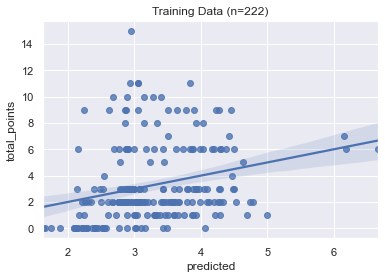

Train RMSE:  2.8769


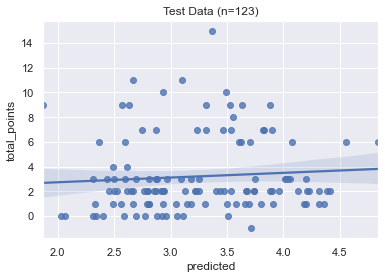

Train RMSE:  3.0414


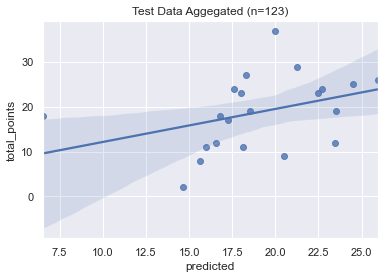

Test RMSE:  7.6307
Defender
reading in /Users/jasongoldrosen/Documents/Jason/fantasy_epl/data/fpl_data18-19.xlsx ...
                            OLS Regression Results                            
Dep. Variable:           total_points   R-squared:                       0.084
Model:                            OLS   Adj. R-squared:                  0.078
Method:                 Least Squares   F-statistic:                     16.31
Date:                Sat, 11 Jul 2020   Prob (F-statistic):           4.92e-18
Time:                        18:03:52   Log-Likelihood:                -2612.8
No. Observations:                1080   AIC:                             5240.
Df Residuals:                    1073   BIC:                             5274.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------

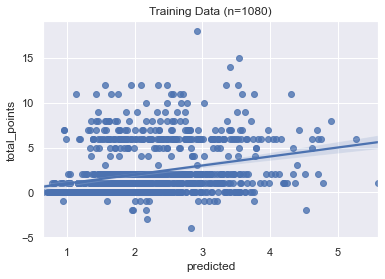

Train RMSE:  2.7191


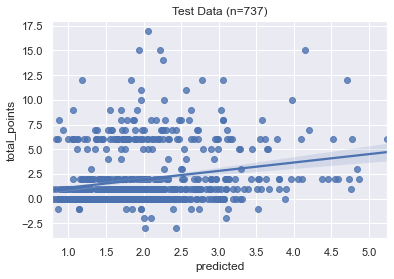

Train RMSE:  2.7396


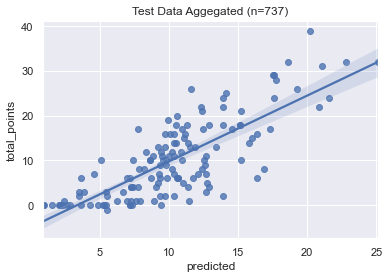

Test RMSE:  5.8373
Midfielder
reading in /Users/jasongoldrosen/Documents/Jason/fantasy_epl/data/fpl_data18-19.xlsx ...
                            OLS Regression Results                            
Dep. Variable:           total_points   R-squared:                       0.106
Model:                            OLS   Adj. R-squared:                  0.102
Method:                 Least Squares   F-statistic:                     26.29
Date:                Sat, 11 Jul 2020   Prob (F-statistic):           1.09e-29
Time:                        18:04:01   Log-Likelihood:                -3263.5
No. Observations:                1339   AIC:                             6541.
Df Residuals:                    1332   BIC:                             6577.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
--------

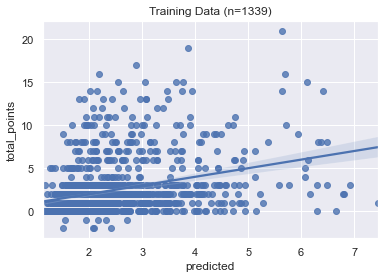

Train RMSE:  2.7686


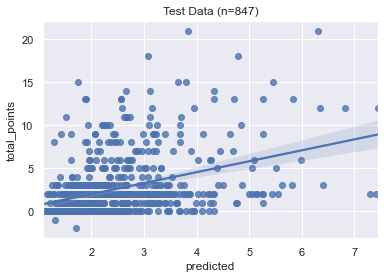

Train RMSE:  2.8664


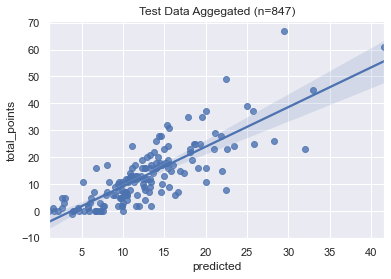

Test RMSE:  7.3705
Forward
reading in /Users/jasongoldrosen/Documents/Jason/fantasy_epl/data/fpl_data18-19.xlsx ...
                            OLS Regression Results                            
Dep. Variable:           total_points   R-squared:                       0.125
Model:                            OLS   Adj. R-squared:                  0.113
Method:                 Least Squares   F-statistic:                     10.25
Date:                Sat, 11 Jul 2020   Prob (F-statistic):           1.29e-10
Time:                        18:04:10   Log-Likelihood:                -1103.9
No. Observations:                 438   AIC:                             2222.
Df Residuals:                     431   BIC:                             2250.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
-----------

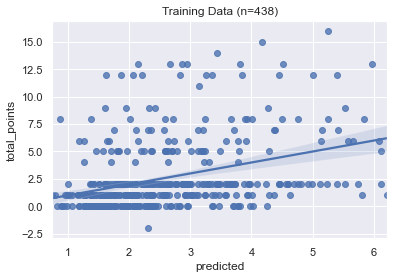

Train RMSE:  3.0082


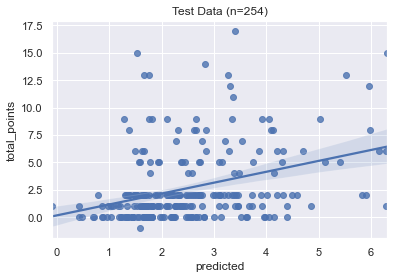

Train RMSE:  3.1451


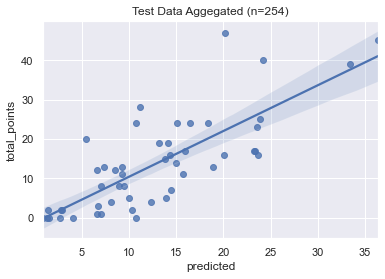

Test RMSE:  7.5195


In [207]:
def calc_rmse(df):
    return (((df['predicted'] - df['total_points']) ** 2).mean()) ** .5



for pos in positions:
    print(pos)
    
    df = get_data()
    df = create_additional_vars(df)

    agg_dict= {
               'xG':'sum', 
               'xA':'sum',
               'team_goals':'sum',
               'ict_index': 'last',
               'value': 'last',
               'minutes': 'sum',
               'total_points':'mean'
                }

    
    train_features, train_targets = compile_data(df=df, 
                                                start_round=6, 
                                                end_round=15, 
                                                var_dict=agg_dict, 
                                                lagged_rounds=5,
                                                position = pos)

    test_features, test_targets = compile_data(df=df, 
                                                start_round=16, 
                                                end_round=21, 
                                                var_dict=agg_dict, 
                                                lagged_rounds=5,
                                                position = pos)


    cols = ['value_5', 'xG_5','xA_5','ict_index_5','team_goals_5', 'total_points_5']


    X = sm.add_constant(train_features[cols])
    y = train_targets

    mod = sm.OLS(y, X)
    res = mod.fit()
    print(res.summary())
    y_pred = res.predict(X)

    # df = y.merge(y_pred, left_index=True,right_index=True)
    df = y.copy()
    df['predicted'] = y_pred
    plt.close()
    # g = sns.scatterplot(x='predicted',y='total_points', data=df)
    ax = sns.regplot(x='predicted',y='total_points', data=df)
    ax.set_title(f'Training Data (n={len(y)})')
    plt.show()
    print(f'Train RMSE: {calc_rmse(df): 0.04f}')

    #Test Data

    X = sm.add_constant(test_features[cols])
    y = test_targets
    y_pred = res.predict(X)

    df = y.copy()
    df['predicted'] = y_pred
    plt.close()
    ax = sns.regplot(x='predicted',y='total_points', data=df)
    ax.set_title(f'Test Data (n={len(y)})')
    plt.show()
    print(f'Train RMSE: {calc_rmse(df): 0.04f}')


    df = df.reset_index().groupby('player_id')[['total_points', 'predicted']].sum()

    plt.close()
    ax = sns.regplot(x='predicted',y='total_points', data=df)
    ax.set_title(f'Test Data Aggegated (n={len(y)})')
    plt.show()
    print(f'Test RMSE: {calc_rmse(df): 0.04f}')


Goalkeeper
reading in /Users/jasongoldrosen/Documents/Jason/fantasy_epl/data/fpl_data18-19.xlsx ...
Forward stepwise subset selection
Number of features | Features | RSS


[(1, ['minutes_5'], 1814.0),
 (2, ['minutes_5', 'value_5'], 1764.0),
 (3, ['minutes_5', 'value_5', 'bonus_5'], 1740.0),
 (4, ['minutes_5', 'value_5', 'bonus_5', 'xA_5'], 1729.0)]

                            OLS Regression Results                            
Dep. Variable:           total_points   R-squared:                       0.117
Model:                            OLS   Adj. R-squared:                  0.105
Method:                 Least Squares   F-statistic:                     9.632
Date:                Tue, 14 Jul 2020   Prob (F-statistic):           5.36e-06
Time:                        22:41:14   Log-Likelihood:                -543.53
No. Observations:                 222   AIC:                             1095.
Df Residuals:                     218   BIC:                             1109.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.5169      2.044     -2.210      0.0

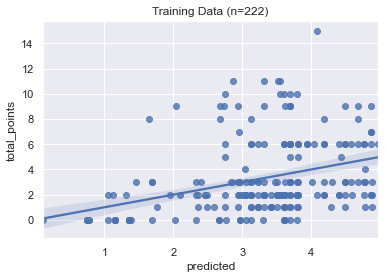

Train RMSE:  2.7993


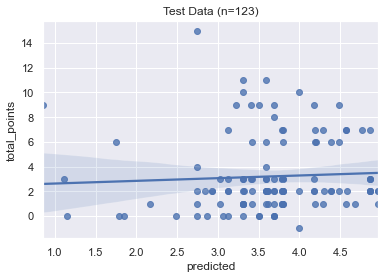

Train RMSE:  3.1142


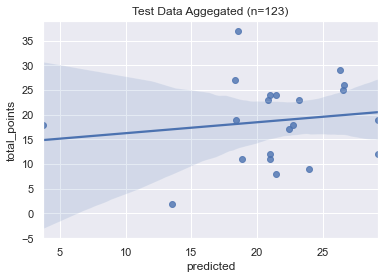

Test RMSE:  9.4662
Defender
reading in /Users/jasongoldrosen/Documents/Jason/fantasy_epl/data/fpl_data18-19.xlsx ...
Forward stepwise subset selection
Number of features | Features | RSS


[(1, ['bps_5'], 8228.0),
 (2, ['bps_5', 'ict_index_5'], 8025.0),
 (3, ['bps_5', 'ict_index_5', 'value_5'], 7955.0),
 (4, ['bps_5', 'ict_index_5', 'value_5', 'selected_5'], 7932.0)]

                            OLS Regression Results                            
Dep. Variable:           total_points   R-squared:                       0.097
Model:                            OLS   Adj. R-squared:                  0.092
Method:                 Least Squares   F-statistic:                     16.54
Date:                Tue, 14 Jul 2020   Prob (F-statistic):           8.36e-21
Time:                        22:41:24   Log-Likelihood:                -2604.5
No. Observations:                1080   AIC:                             5225.
Df Residuals:                    1072   BIC:                             5265.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -1.3063      0.817     -1.

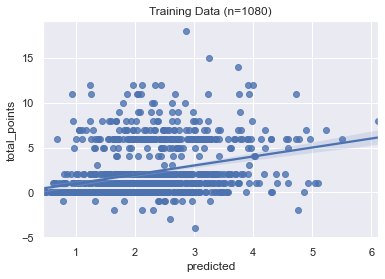

Train RMSE:  2.6984


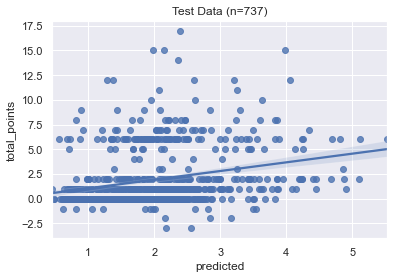

Train RMSE:  2.7096


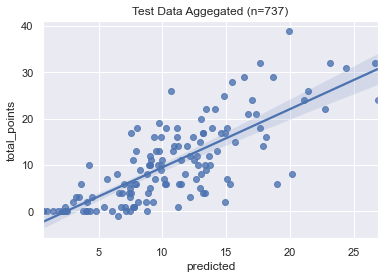

Test RMSE:  5.8024
Midfielder
reading in /Users/jasongoldrosen/Documents/Jason/fantasy_epl/data/fpl_data18-19.xlsx ...
Forward stepwise subset selection
Number of features | Features | RSS


[(1, ['value_5'], 10529.0),
 (2, ['value_5', 'minutes_5'], 10280.0),
 (3, ['value_5', 'minutes_5', 'threat_5'], 10173.0),
 (4, ['value_5', 'minutes_5', 'threat_5', 'selected_5'], 10160.0)]

                            OLS Regression Results                            
Dep. Variable:           total_points   R-squared:                       0.114
Model:                            OLS   Adj. R-squared:                  0.112
Method:                 Least Squares   F-statistic:                     57.11
Date:                Tue, 14 Jul 2020   Prob (F-statistic):           9.89e-35
Time:                        22:41:34   Log-Likelihood:                -3257.6
No. Observations:                1339   AIC:                             6523.
Df Residuals:                    1335   BIC:                             6544.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.3314      0.358     -3.717      0.0

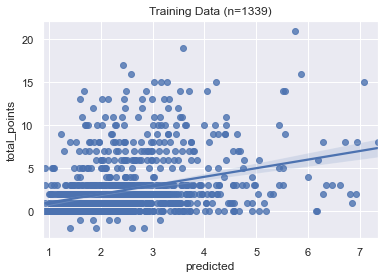

Train RMSE:  2.7564


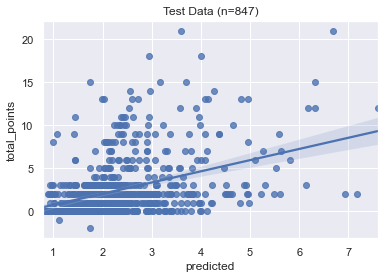

Train RMSE:  2.8539


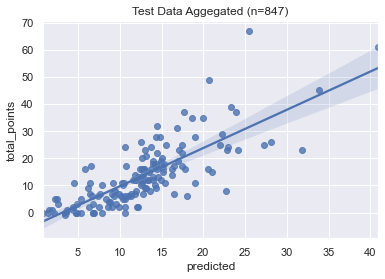

Test RMSE:  7.5877
Forward
reading in /Users/jasongoldrosen/Documents/Jason/fantasy_epl/data/fpl_data18-19.xlsx ...
Forward stepwise subset selection
Number of features | Features | RSS


[(1, ['value_5'], 4116.0),
 (2, ['value_5', 'creativity_5'], 4013.0),
 (3, ['value_5', 'creativity_5', 'minutes_5'], 3971.0),
 (4, ['value_5', 'creativity_5', 'minutes_5', 'red_cards_5'], 3948.0)]

                            OLS Regression Results                            
Dep. Variable:           total_points   R-squared:                       0.150
Model:                            OLS   Adj. R-squared:                  0.135
Method:                 Least Squares   F-statistic:                     9.499
Date:                Tue, 14 Jul 2020   Prob (F-statistic):           4.01e-12
Time:                        22:41:45   Log-Likelihood:                -1097.4
No. Observations:                 438   AIC:                             2213.
Df Residuals:                     429   BIC:                             2249.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.7329      0.661     

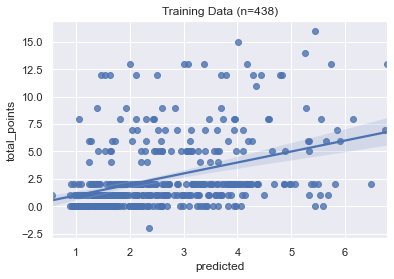

Train RMSE:  2.9638


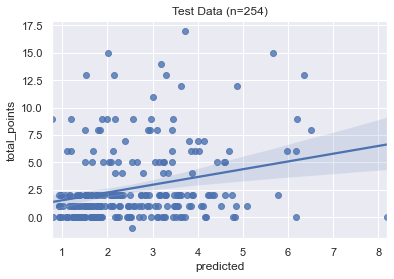

Train RMSE:  3.2586


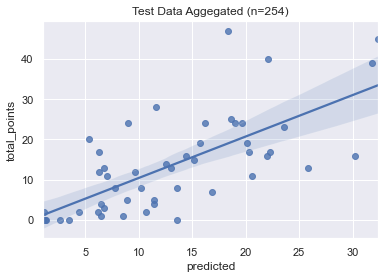

Test RMSE:  8.5117


In [270]:
for pos in positions:
    print(pos)

    df = get_data()
    df = create_additional_vars(df)

    agg_dict= {
               #'goals_scored':'sum',
               #'assists':'sum',
               'xG':'sum', 
               'xA':'sum',
                'total_points':'sum',
               'minutes':'sum',
               'selected': 'last',
               'net_transfers':'last',
               'team_goals':'sum',
               'bonus': 'sum',
               'bps':'sum',
               'influence': 'last',
               'creativity': 'last',
               'threat': 'last',
               'ict_index': 'last',
               'yellow_cards': 'sum',
               'red_cards': 'sum',
               'value': 'last'
                }


    train_features, train_targets = compile_data(df=df, 
                                                start_round=6, 
                                                end_round=15, 
                                                var_dict=agg_dict, 
                                                lagged_rounds=5,
                                                position = pos)

    test_features, test_targets = compile_data(df=df, 
                                                start_round=16, 
                                                end_round=21, 
                                                var_dict=agg_dict, 
                                                lagged_rounds=5,
                                                position = pos)
    
    #Variable selection
    X = sm.add_constant(train_features)
    Y = train_targets.total_points
    best_features_list = stepwise_selection(X,Y)
    
    #Train model with selected variables
    X = sm.add_constant(train_features[best_features_list])
    y = train_targets

    mod = sm.OLS(y, X)
    res = mod.fit()
    print(res.summary())
    y_pred = res.predict(X)

    df = y.copy()
    df['predicted'] = y_pred
    plt.close()

    ax = sns.regplot(x='predicted',y='total_points', data=df)
    ax.set_title(f'Training Data (n={len(y)})')
    plt.show()
    print(f'Train RMSE: {calc_rmse(df): 0.04f}')

    #Test Data

    X = sm.add_constant(test_features[best_features_list])
    y = test_targets
    y_pred = res.predict(X)

    df = y.copy()
    df['predicted'] = y_pred
    plt.close()
    ax = sns.regplot(x='predicted',y='total_points', data=df)
    ax.set_title(f'Test Data (n={len(y)})')
    plt.show()
    print(f'Train RMSE: {calc_rmse(df): 0.04f}')


    df = df.reset_index().groupby('player_id')[['total_points', 'predicted']].sum()

    plt.close()
    ax = sns.regplot(x='predicted',y='total_points', data=df)
    ax.set_title(f'Test Data Aggegated (n={len(y)})')
    plt.show()
    print(f'Test RMSE: {calc_rmse(df): 0.04f}')

## TODO

Short Terms
- Make predictions for other poisitions (DONE)
- Model selection for each position
- Include fixture difficulty and home/away indicators
- Compare results against some ML model instead

Medium Term
- Combine with LP Solve

Long Term
- Bring in betting market data/something forward looking

In [209]:
import itertools
import time
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

In [234]:
df = get_data()
df = create_additional_vars(df)

agg_dict= {
           #'goals_scored':'sum',
           #'assists':'sum',
           'xG':'sum', 
           'xA':'sum',
            'total_points':'sum',
           'minutes':'sum',
           'selected': 'last',
           'net_transfers':'last',
           'team_goals':'sum',
           'bonus': 'sum',
           'bps':'sum',
           'influence': 'last',
           'creativity': 'last',
           'threat': 'last',
           'ict_index': 'last',
           'yellow_cards': 'sum',
           'red_cards': 'sum',
           'value': 'last'
            }


train_features, train_targets = compile_data(df=df, 
                                            start_round=6, 
                                            end_round=15, 
                                            var_dict=agg_dict, 
                                            lagged_rounds=5,
                                            position = pos)

test_features, test_targets = compile_data(df=df, 
                                            start_round=16, 
                                            end_round=21, 
                                            var_dict=agg_dict, 
                                            lagged_rounds=5,
                                            position = pos)



reading in /Users/jasongoldrosen/Documents/Jason/fantasy_epl/data/fpl_data18-19.xlsx ...


In [236]:
train_features

xG_5  xA_5  total_points_5  minutes_5  selected_5  \
player_id round                                                      
21        9         1     1              17        115       37826   
          10        0     1               9        100       37648   
          11        0     1               9        116       38199   
          12        0     1               9        115       38201   
          13        0     1               8        105       36454   
...               ...   ...             ...        ...         ...   
524       11        3     1              12        221      119724   
          12        3     2              13        303      194544   
          13        3     2              14        383      210787   
          14        1     2              14        398      219547   
          15        2     2              14        453      228059   

                 net_transfers_5  team_goals_5  bonus_5  bps_5  influence_5  \
player_id round                                                               
21        9                -1356            17        3     60         26.0   
          10               -1120            17        0     30          0.0   
          11                 -26            16        0     29          3.2   
          12                -722            15        0     29          0.0   
          13               -2162            14        0     28          0.0   
...                          ...           ...      ...    ...          ...   
524       11               14007             7        0     41         42.4   
          12               69810             6        0     51         13.2   
          13               17446             6        0     59         10.6   
          14                7045             6        0     67          0.2   
          15                7817             6        0     58          1.8   

                 creativity_5  threat_5  ict_index_5  yellow_cards_5  \
player_id round                                                        
21        9              33.1         4          6.3               0   
          10              0.0         0          0.0               0   
          11              0.3         0          0.4               0   
          12              0.1         4          0.3               0   
          13              0.0         0          0.0               0   
...                       ...       ...          ...             ...   
524       11             38.3        47         12.8               0   
          12             33.7        51          9.8               0   
          13             25.6        20          5.6               0   
          14             10.9         4          1.5               0   
          15             17.1        16          3.5               1   

                 red_cards_5  value_5  
player_id round                        
21        9                0      6.5  
          10               0      6.5  
          11               0      6.5  
          12               0      6.5  
          13               0      6.5  
...                      ...      ...  
524       11               0      4.5  
          12               0      4.6  
          13               0      4.6  
          14               0      4.6  
          15               0      4.6  

[438 rows x 16 columns]

In [268]:

def stepwise_selection(X,Y):
    #Initialization variables
#     X = sm.add_constant(train_features)
    X = train_features
    Y = train_targets.total_points
    k = X.shape[1]

    remaining_features = list(X.columns.values)
    features = []
    RSS_list, R_squared_list = [np.inf], [np.inf] #Due to 1 indexing of the loop...
    features_list = dict()

    for i in range(1,k+1):
        best_RSS = np.inf

        for combo in itertools.combinations(remaining_features,1):

                RSS = fit_linear_reg(X[list(combo) + features],Y)   #Store temp result 

                if RSS[0] < best_RSS:
                    best_RSS = RSS[0]
                    best_R_squared = RSS[1] 
                    best_feature = combo[0]

        #Updating variables for next loop
        features.append(best_feature)
        remaining_features.remove(best_feature)

        #Saving values for plotting
        RSS_list.append(best_RSS)
        R_squared_list.append(best_R_squared)
        features_list[i] = features.copy()

    print('Forward stepwise subset selection')
    print('Number of features |', 'Features |', 'RSS')
    display([(i,features_list[i], round(RSS_list[i])) for i in range(1,5)])    

    df1 = pd.concat([pd.DataFrame({'features':features_list}),pd.DataFrame({'RSS':RSS_list, 'R_squared': R_squared_list})], axis=1, join='inner')
    df1['numb_features'] = df1.index

    #Initializing useful variables
    m = len(Y)
    p = 11
    hat_sigma_squared = (1/(m - p -1)) * min(df1['RSS'])

    #Computing
    df1['C_p'] = (1/m) * (df1['RSS'] + 2 * df1['numb_features'] * hat_sigma_squared )
    df1['AIC'] = (1/(m*hat_sigma_squared)) * (df1['RSS'] + 2 * df1['numb_features'] * hat_sigma_squared )
    df1['BIC'] = (1/(m*hat_sigma_squared)) * (df1['RSS'] +  np.log(m) * df1['numb_features'] * hat_sigma_squared )
    df1['R_squared_adj'] = 1 - ( (1 - df1['R_squared'])*(m-1)/(m-df1['numb_features'] -1))

    #Storing best features
    min_aic = df1.AIC.min()
    best_features_list = df1.loc[df1.AIC == min_aic,'features'].values[0]
    return best_features_list


In [239]:
#Initialization variables
X = sm.add_constant(train_features)
Y = train_targets.total_points
k = train_features.shape[1]

remaining_features = list(X.columns.values)
features = []
RSS_list, R_squared_list = [np.inf], [np.inf] #Due to 1 indexing of the loop...
features_list = dict()

for i in range(1,k+1):
    best_RSS = np.inf
    
    for combo in itertools.combinations(remaining_features,1):

            RSS = fit_linear_reg(X[list(combo) + features],Y)   #Store temp result 

            if RSS[0] < best_RSS:
                best_RSS = RSS[0]
                best_R_squared = RSS[1] 
                best_feature = combo[0]

    #Updating variables for next loop
    features.append(best_feature)
    remaining_features.remove(best_feature)
    
    #Saving values for plotting
    RSS_list.append(best_RSS)
    R_squared_list.append(best_R_squared)
    features_list[i] = features.copy()
    
    

In [240]:
print('Forward stepwise subset selection')
print('Number of features |', 'Features |', 'RSS')
display([(i,features_list[i], round(RSS_list[i])) for i in range(1,5)])

Forward stepwise subset selection
Number of features | Features | RSS


[(1, ['value_5'], 4116.0),
 (2, ['value_5', 'creativity_5'], 4013.0),
 (3, ['value_5', 'creativity_5', 'minutes_5'], 3971.0),
 (4, ['value_5', 'creativity_5', 'minutes_5', 'red_cards_5'], 3948.0)]

In [243]:
df1 = pd.concat([pd.DataFrame({'features':features_list}),pd.DataFrame({'RSS':RSS_list, 'R_squared': R_squared_list})], axis=1, join='inner')
df1['numb_features'] = df1.index

In [244]:
#Initializing useful variables
m = len(Y)
p = 11
hat_sigma_squared = (1/(m - p -1)) * min(df1['RSS'])

#Computing
df1['C_p'] = (1/m) * (df1['RSS'] + 2 * df1['numb_features'] * hat_sigma_squared )
df1['AIC'] = (1/(m*hat_sigma_squared)) * (df1['RSS'] + 2 * df1['numb_features'] * hat_sigma_squared )
df1['BIC'] = (1/(m*hat_sigma_squared)) * (df1['RSS'] +  np.log(m) * df1['numb_features'] * hat_sigma_squared )
df1['R_squared_adj'] = 1 - ( (1 - df1['R_squared'])*(m-1)/(m-df1['numb_features'] -1))
df1


min_aic = df1.AIC.min()
best_features_list = df1.loc[df1.AIC == min_aic,'features'].values[0]
best_features_dict = {}
best_features_dict.update({pos: best_features})

,features,RSS,R_squared,numb_features,C_p,AIC,BIC,R_squared_adj
1,[value_5],4115.568410,0.091301,1,9.437084,1.055935,1.065255,0.089217
2,"[value_5, creativity_5]",4013.130971,0.113919,2,9.244018,1.034333,1.052973,0.109845
3,"[value_5, creativity_5, minutes_5]",3971.076048,0.123205,3,9.188811,1.028156,1.056116,0.117144
4,"[value_5, creativity_5, minutes_5, red_cards_5]",3948.148146,0.128267,4,9.177273,1.026865,1.064145,0.120214
5,"[value_5, creativity_5, minutes_5, red_cards_5...",3930.548237,0.132153,5,9.177900,1.026935,1.073535,0.122109
6,"[value_5, creativity_5, minutes_5, red_cards_5...",3918.480766,0.134817,6,9.191157,1.028418,1.084339,0.122773
7,"[value_5, creativity_5, minutes_5, red_cards_5...",3907.986562,0.137135,7,9.208007,1.030303,1.095544,0.123088
8,"[value_5, creativity_5, minutes_5, red_cards_5...",3847.534284,0.150482,8,9.110797,1.019426,1.093987,0.134640
9,"[value_5, creativity_5, minutes_5, red_cards_5...",3836.362697,0.152949,9,9.126100,1.021139,1.105020,0.135137
10,"[value_5, creativity_5, minutes_5, red_cards_5...",3829.482406,0.154468,10,9.151201,1.023947,1.117149,0.134666


In [251]:
min_aic = df1.AIC.min()
best_features_list = df1.loc[df1.AIC == min_aic,'features'].values[0]
best_features_dict = {}
best_features_dict.update({pos: best_features})

In [261]:
best_features_dict = {}
best_features_dict.update({pos: best_features})


In [262]:
best_features_dict.update( {'test': best_features} )

In [263]:
best_features_dict

{'Forward': ['value_5',
  'creativity_5',
  'minutes_5',
  'red_cards_5',
  'selected_5',
  'net_transfers_5',
  'total_points_5',
  'bps_5'],
 'test': ['value_5',
  'creativity_5',
  'minutes_5',
  'red_cards_5',
  'selected_5',
  'net_transfers_5',
  'total_points_5',
  'bps_5']}